In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential
from keras.layers import Layer, Flatten, Dense,Dropout, Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import plot_model

In [2]:
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.optimizers import Adam

In [ ]:

tf.keras.backend.clear_session()

# Release GPU memory (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to allocate memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Close all TensorFlow session handles
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=-1)])
        sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
        sess.close()

    except RuntimeError as e:
        print(e)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loaded_model = load_model('/content/drive/MyDrive')

In [6]:
pos_df = pd.read_csv("/content/drive/MyDrive/zanam/pos_him_iit_aug.csv")
# pos_df = pd.read_csv("csv/pos_aug.csv")

In [7]:
neg_df = pd.read_csv("/content/drive/MyDrive/zanam/neg_him_iit_aug.csv")
# neg_df = pd.read_csv("csv/neg_aug.csv")

In [8]:
len(pos_df), len(neg_df)

(10586, 10586)

In [9]:
pos_df["label"] = 1
neg_df["label"] = 0

In [10]:
pos_df.head()

,image1,image2,label
0,iit_001_01_L.bmp,iit_001_02_L.bmp,1
1,iit_001_01_L.bmp,iit_001_03_L.bmp,1
2,iit_001_01_L.bmp,iit_001_04_L.bmp,1
3,iit_001_01_L.bmp,iit_001_04_L_aug1.bmp,1
4,iit_001_01_L.bmp,iit_001_04_L_aug2.bmp,1


In [ ]:
pos_df.shape

(6058, 3)

In [ ]:
neg_df

,image1,image2,label
0,iit_131_04_L.bmp,iit_044_02_L.bmp,0
1,iit_144_09_R.bmp,iit_044_01_L.bmp,0
2,iit_177_09_R.bmp,iit_014_05_L.bmp,0
3,iit_198_09_R.bmp,iit_044_04_L.bmp,0
4,iit_028_07_R.bmp,iit_124_06_R.bmp,0
...,...,...,...
6053,iit_003_08_L.bmp,iit_073_05_L.bmp,0
6054,iit_170_05_L.bmp,iit_196_09_R.bmp,0
6055,iit_001_10_L.bmp,iit_209_07_R.bmp,0
6056,iit_077_04_L.bmp,iit_047_03_L.bmp,0


In [12]:
df = pd.concat([pos_df, neg_df])

In [13]:
df = df.sample(frac=1).reset_index(drop=True)

In [14]:
image1=tf.data.Dataset.from_tensor_slices('/content/drive/MyDrive/zanam/himansu_iit_aug/'+df['image1'])
image2=tf.data.Dataset.from_tensor_slices('/content/drive/MyDrive/zanam/himansu_iit_aug/'+df['image2'])
labels=tf.data.Dataset.from_tensor_slices(df['label'])

In [15]:
%load_ext tensorboard

In [16]:
import os
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)
import datetime
def create_tensorboard_callback():
  logdir = os.path.join("iris_logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)
tensorBoard = create_tensorboard_callback()
checkpoint_dir = "new_checkpoints/checkpoint.keras"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'auto',
    save_freq='epoch',
)

In [17]:
def load_and_preprocess_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_bmp(image, channels=0)
    # image=tf.image.grayscale_to_rgb(image)

    image = tf.image.resize(image, size = (224,224))
    image = image/255.0
    return image

In [18]:
image1_dataset = image1.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
image2_dataset = image2.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [19]:
batch_size = 32
image1_dataset_features = image1_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
image2_dataset_features = image2_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
labels=labels.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [20]:
len(labels)

662

In [21]:
len(image1_dataset_features)

662

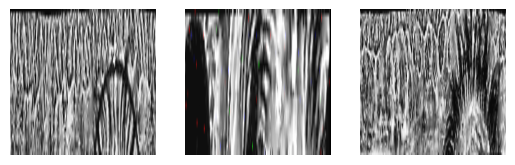

In [22]:
imgbatch=image1_dataset_features.as_numpy_iterator().next()

for i in range(3):
  plt.subplot(1,3,i+1)
  # plt.imshow(imgbatch[i].astype('uint8'))
  plt.imshow(imgbatch[i])
  plt.axis('off')


In [23]:
def format_data(image1, image2, labels):
    return (image1, image2), labels
ds = tf.data.Dataset.zip((image1_dataset_features, image2_dataset_features, labels)).map(format_data)

In [24]:
total_batches=tf.data.experimental.cardinality(ds)
print(total_batches)

tf.Tensor(662, shape=(), dtype=int64)


In [25]:
len(ds)

662

In [26]:


test_ds=ds.take(total_batches//50)
train_ds=ds.skip(total_batches//50)

In [27]:
train_batches=tf.data.experimental.cardinality(train_ds)
train_batches

<tf.Tensor: shape=(), dtype=int64, numpy=649>

In [28]:
# train_ds = train_ds.shuffle(1000)

In [29]:
val_ds = train_ds.take(train_batches//5)
train_ds = train_ds.skip(train_batches//5)

In [30]:
print(len(val_ds))
print(len(train_ds))
print(len(test_ds))

129
520
13


In [31]:
from keras import layers,models
from keras.applications import VGG16
from sklearn.model_selection import KFold
from keras.models import load_model
input_shape=(224,224,3)

In [32]:
images,labels=test_ds.as_numpy_iterator().next()
image1,image2=images

In [33]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable=False
pooling=layers.GlobalAveragePooling2D()
distance = layers.Lambda(lambda x: K.abs(x[0] - x[1]), name='distance')
prediction = layers.Dense(1, activation='sigmoid', name='output')

58889256/58889256 [==============================] - 0s 0us/step


In [34]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
def load_and_preprocess_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_bmp(image, channels=0)
    # image=tf.image.grayscale_to_rgb(image)

    image = tf.image.resize(image, size = (224,224))
    image = image/255.0
    return image

base_model.trainable=False
pooling=layers.GlobalAveragePooling2D()
distance = layers.Lambda(lambda x: K.abs(x[0] - x[1]), name='distance')
prediction = layers.Dense(1, activation='sigmoid', name='output')

In [35]:
len(base_model.layers)

19

In [36]:
input_shape=(224,224,3)
input_a = layers.Input(shape=input_shape, name='input_a')
input_b = layers.Input(shape=input_shape, name='input_b')


output_a=base_model(input_a,training=False)
output_b=base_model(input_b,training=False)

pooled_op_a=pooling(output_a)
pooled_op_b=pooling(output_b)

siamese=distance([pooled_op_a, pooled_op_b])
output=prediction(siamese)

model=tf.keras.Model(inputs=[input_a, input_b], outputs=output, name='siamese_vgg19')


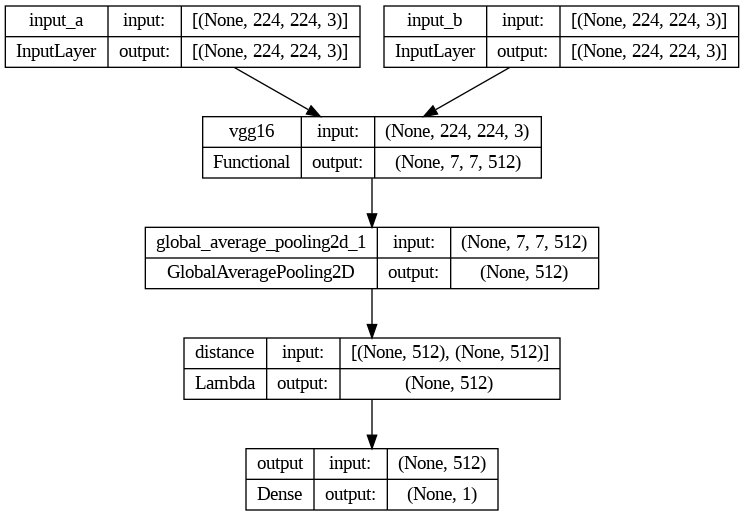

In [37]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [38]:
from keras.losses import binary_crossentropy

In [ ]:
# compile the model
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
              loss=binary_crossentropy,
              metrics=['accuracy'])


history = model.fit(train_ds,verbose=1,epochs=10,validation_data=val_ds, callbacks=[early_stopping, tensorBoard])

Epoch 1/10


In [ ]:
model.save("/content/drive/MyDrive/zanam/zanam_vgg16.keras")
model.save("/content/drive/MyDrive/zanam/zanam_vgg16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model1 = load_model("from_resnet.keras",safe_mode=False)

## finetune

In [ ]:
model1.summary()

Model: "siamese_vgg16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_a (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_b (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_a[0][0]',             
                                                          2          'input_b[0][0]']             
                                                                                                  
 global_average_pooling2d (  (None, 2048)                 0         ['resnet50[0][0]',

In [ ]:
learning_rate = 0.0001
base_model.trainable = True
fine_tune_at = 140
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable=False
model.compile(optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                      loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics = ["accuracy"])
# Fit the model using generators
def create_tensorboard_callback():
  logdir = os.path.join("iris_logs/finetune",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)
tensorBoard = create_tensorboard_callback()
# checkpoint_dir = "/content/drive/MyDrive/new_checkpoints/fientune/checkpoint.keras"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)
history_fine = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    shuffle=True,
                    callbacks=[early_stopping, tensorBoard]
                  )


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


298/298 [==============================] - 118s 340ms/step - loss: 0.4381 - accuracy: 0.8509 - val_loss: 0.4293 - val_accuracy: 0.8526
Epoch 2/10
298/298 [==============================] - 118s 341ms/step - loss: 0.4365 - accuracy: 0.8517 - val_loss: 0.4277 - val_accuracy: 0.8530
Epoch 3/10
298/298 [==============================] - 116s 337ms/step - loss: 0.4350 - accuracy: 0.8522 - val_loss: 0.4262 - val_accuracy: 0.8535
Epoch 4/10
298/298 [==============================] - 134s 401ms/step - loss: 0.4335 - accuracy: 0.8522 - val_loss: 0.4248 - val_accuracy: 0.8530
Epoch 5/10
298/298 [==============================] - 115s 336ms/step - loss: 0.4321 - accuracy: 0.8516 - val_loss: 0.4234 - val_accuracy: 0.8530
Epoch 6/10
298/298 [==============================] - 114s 332ms/step - loss: 0.4306 - accuracy: 0.8513 - val_loss: 0.4220 - val_accuracy: 0.8530


In [ ]:
model.save('final_fine2.keras')
model.save('final_fine2.h5')

In [ ]:
# model_save_path = "/content/drive/MyDrive/zanam/history2_FINE.pkl"
# with open(model_save_path, 'wb') as file:
#   pickle.dump(history_fine.history, file)

In [ ]:
# model_load_path = "/content/drive/MyDrive/zanam/history2_FINE.pkl"
# with open(model_load_path, 'rb') as file:
#   loaded_history_fine = pickle.load(file)

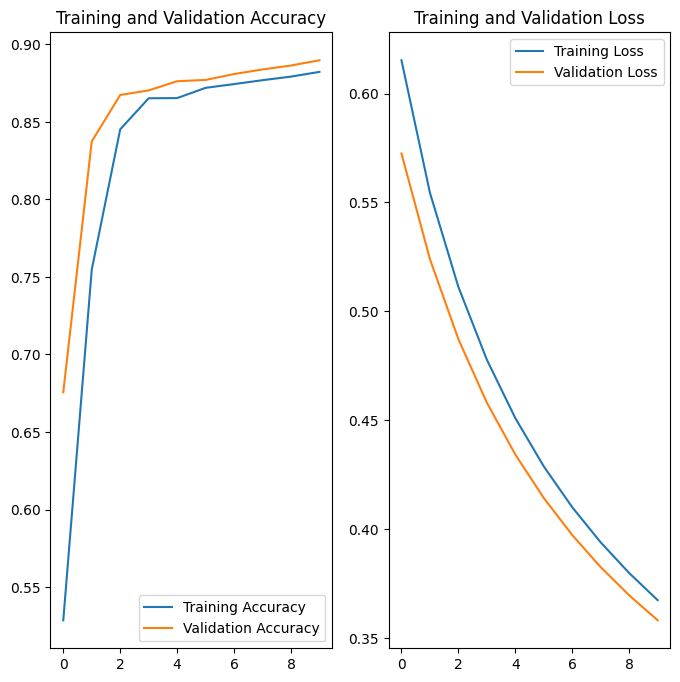

In [ ]:
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('test.png')
plt.show()

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

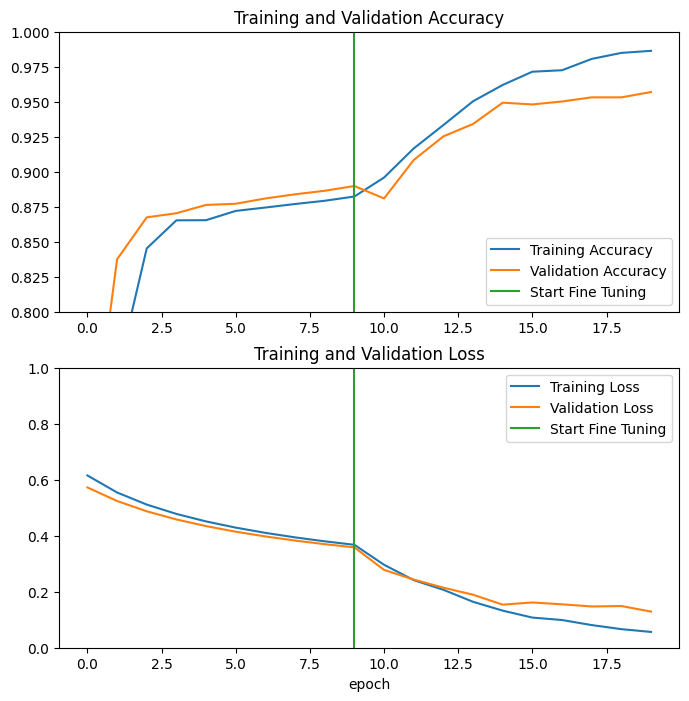

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([10-1,10-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([10-1,10-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

7


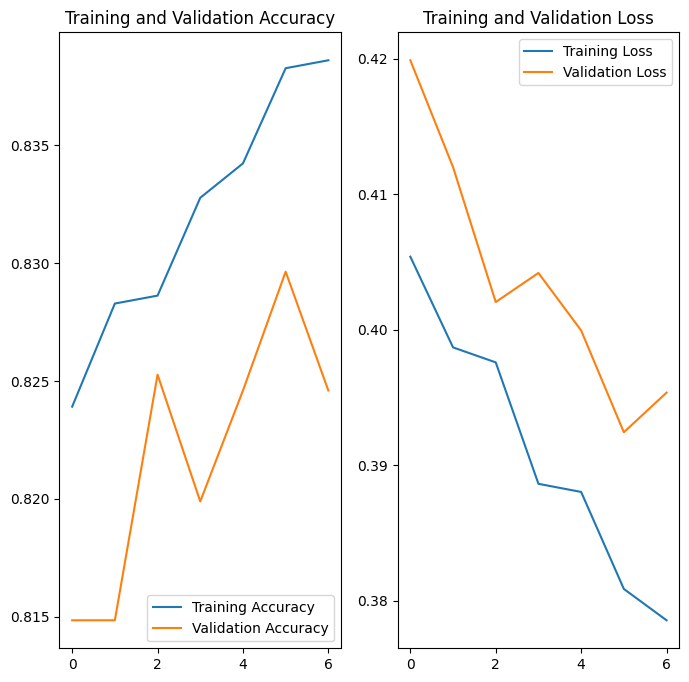

In [ ]:
# epochs = len(loaded_history_fine['accuracy'])
# print(epochs)
# acc = loaded_history_fine['accuracy']
# val_acc = loaded_history_fine['val_accuracy']

# loss =loaded_history_fine['loss']
# val_loss = loaded_history_fine['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.savefig('test.png')
# plt.show()

In [ ]:
!tensorboard --logdir="iris_logs/20240308-155819"

2024-03-09 21:15:10.810342: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 21:15:10.810380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 21:15:10.811204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 21:15:10.816224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 21:15:11.447051: W tensorflow/compiler/tf2

In [ ]:
model_path = "final_fine_vgg16.h5"

In [ ]:
from keras.models import load_model

In [ ]:
loaded_model = load_model(model_path,safe_mode = False)

ValueError: bad marshal data (unknown type code)

In [ ]:
mmu_pos_df = pd.read_csv("/content/drive/MyDrive/zanam/pos_him_mmu.csv")
mmu_neg_df = pd.read_csv("/content/drive/MyDrive/zanam/neg_him_mmu.csv")
mmu_pos_df["label"] = 1
mmu_neg_df["label"] = 0
mmu_df = pd.concat([mmu_pos_df, mmu_neg_df])
mmu_df = mmu_df.sample(frac=1).reset_index(drop=True)

In [ ]:
res_df = mmu_df.sample(frac = 0.5)
len(res_df)

876

In [ ]:

mmu_image1=tf.data.Dataset.from_tensor_slices('/content/drive/MyDrive/zanam/himansu_mmu/'+mmu_df['image1'])
mmu_image2=tf.data.Dataset.from_tensor_slices('/content/drive/MyDrive/zanam/himansu_mmu/'+mmu_df['image2'])
mmu_labels=tf.data.Dataset.from_tensor_slices(mmu_df['label'])

In [ ]:
mmu_image1_dataset = mmu_image1.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
mmu_image2_dataset = mmu_image2.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

batch_size = 32
mmu_image1_dataset_features = mmu_image1_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
mmu_image2_dataset_features = mmu_image2_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
mmu_labels=mmu_labels.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

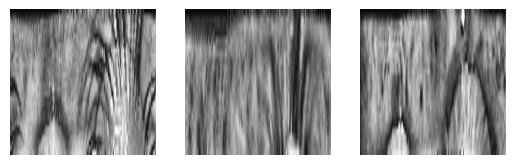

In [ ]:
imgbatch=mmu_image1_dataset_features.as_numpy_iterator().next()

for i in range(3):
  plt.subplot(1,3,i+1)
  # plt.imshow(imgbatch[i].astype('uint8'))
  plt.imshow(imgbatch[i])
  plt.axis('off')


In [ ]:
def format_data(image1, image2, labels):
    return (image1, image2), labels
mmu_ds = tf.data.Dataset.zip((mmu_image1_dataset_features, mmu_image2_dataset_features, mmu_labels)).map(format_data)

In [ ]:
total_test_batches = tf.data.experimental.cardinality(mmu_ds)

total_test_batches

<tf.Tensor: shape=(), dtype=int64, numpy=55>

In [ ]:
num_batches_test_ds = tf.data.experimental.cardinality(test_ds).numpy()

# Divide test_ds by 3
onethird_ds = mmu_ds.take(num_batches_test_ds // 3)

# Create a new dataset from ds with enough batches to match the number of batches in the first half of test_ds
# new_ds = ds.take(num_batches_test_ds)

# Concatenate the first half of test_ds with new_ds
result_ds = onethird_ds.concatenate(test_ds)

In [ ]:
new_ds = mmu_ds.skip(7)
new_ds = new_ds.concatenate(test_ds)

In [ ]:
from sklearn.metrics import roc_curve, auc

# Initialize empty lists to store labels and predictions
true_labels = []
all_predictions = []
without_threshold=[]

# Iterate through the test dataset and gather labels and predictions
for images, labels in new_ds:
    true_labels.extend(labels.numpy())  # Assuming labels are tensors, convert to numpy array
    batch_predictions = model.predict(images)
    without_threshold.extend(batch_predictions)
    batch_predictions = (batch_predictions > 0.5).astype(int)  # Convert probabilities to class labels
    all_predictions.extend(batch_predictions)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
all_predictions = np.array(all_predictions)

# Compute ROC curve and AUC-ROC
fpr, tpr, thresholds = roc_curve(true_labels, without_threshold)
roc_auc = auc(fpr, tpr)

1/1 [==============================] - 0s 77ms/step


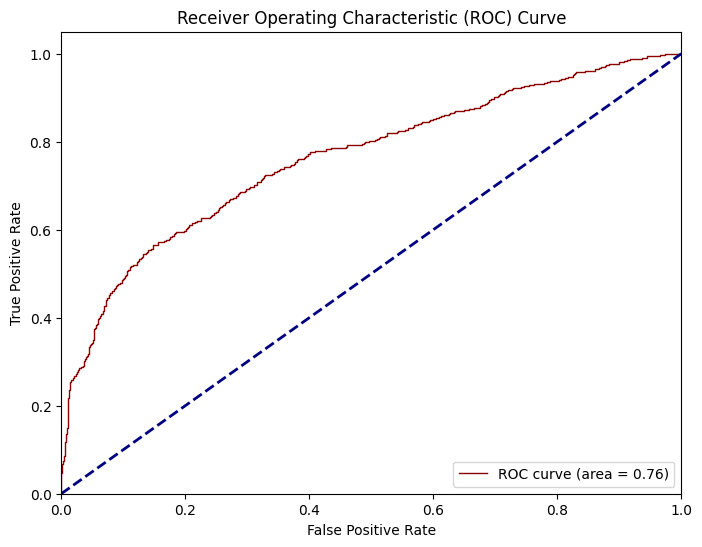

(array([0.        , 0.60743322, 1.        ]),
 array([0.        , 0.85297419, 1.        ]),
 array([2, 1, 0]))

In [ ]:
import matplotlib.pyplot as plt
# Plott ROC curve
plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr, tpr, color='darkred', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('vgg16_roc.png')
plt.show()
roc_curve(true_labels, all_predictions)

In [ ]:
import seaborn as sns

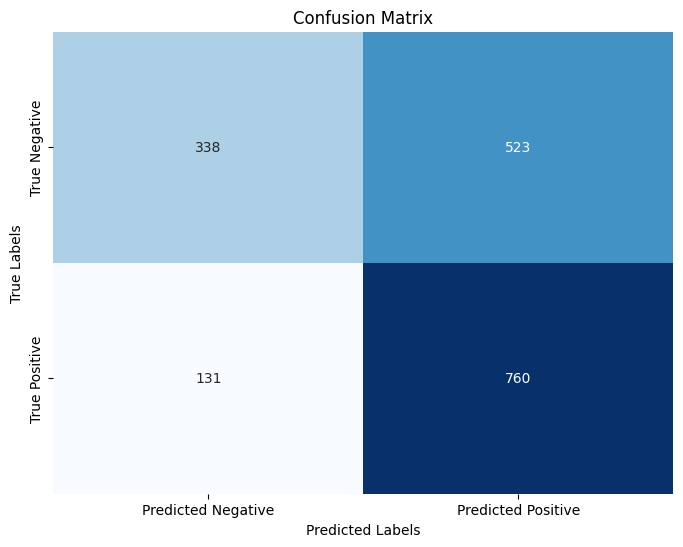

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('resnet_confusion')
plt.show()

In [ ]:
!python --version

Python 3.11.8
